In [4]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from pandas_profiling import ProfileReport


# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [5]:
# Load Data as 
test = pd.read_csv('../../../input/wine_quality/data/test.csv')
train = pd.read_csv('../../../input/wine_quality/data/train.csv')
combine = [test, train]

# 1. Data Analysis

In [6]:
print('\033[0m\033[94m*' * 21)
print('\033[94m\033[1m'+'.: Train Dataset :.')
print('\033[0m\033[94m*' * 21)
train.head().style.background_gradient(cmap="Greens").set_properties(**{'font-family': 'Segoe UI'}).hide_index()

*********************
.: Train Dataset :.
*********************


index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5,5.600000,0.695000,0.060000,6.800000,0.042000,9.000000,84.000000,0.994320,3.440000,0.440000,10.200000,white
1,5,8.800000,0.610000,0.140000,2.400000,0.067000,10.000000,42.000000,0.996900,3.190000,0.590000,9.500000,red
2,5,7.900000,0.210000,0.390000,2.000000,0.057000,21.000000,138.000000,0.991760,3.050000,0.520000,10.900000,white
3,6,7.000000,0.210000,0.310000,6.000000,0.046000,29.000000,108.000000,0.993900,3.260000,0.500000,10.800000,white
4,6,7.800000,0.400000,0.260000,9.500000,0.059000,32.000000,178.000000,0.995500,3.040000,0.430000,10.900000,white


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB


In [8]:
ProfileReport(train, title='Train Dataset', minimal=True, progress_bar=False, 
              samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': '#219EBC'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

* df_index는 뭐하는 거야? 
    * 그냥 index네..
* quality는 3에서 9까지 존재함
* quality는 6이 가장 흔함.
* quality의 분포는 gaussian느낌
* fixed acidity mean = 7.2, var = 1.6 가진 gaussian
* volatile acidity는 mean = 0.3, var = 0.02이고 좀 왼쪽으로 많이 치우쳐진 gaussian.
* volatile acidity의 max는 1.58 minimum은 0.08
* citric acid는 mean = 0.3, var = 0.02인 gaussian임.
* citric acid는 value가 0인게 너무 많은데 이건 잘못된걸까? 아니면 원래 그런걸까? 
* max는 1.66임
* 그외에도 비슷한 느낌임. 특이한 data type이나 눈여겨볼만한 distribution은 없음.

In [9]:
train.describe()

,df_index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000
mean,2748.000000,5.818992,7.210115,0.338163,0.318543,5.438075,0.055808,30.417682,115.566491,0.994673,3.219502,0.530524,10.504918
std,1586.991546,0.870311,1.287579,0.163224,0.145104,4.756676,0.034653,17.673881,56.288223,0.003014,0.160713,0.149396,1.194524
min,0.000000,3.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,1374.000000,5.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992300,3.110000,0.430000,9.500000
50%,2748.000000,6.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994800,3.210000,0.510000,10.300000
75%,4122.000000,6.000000,7.700000,0.400000,0.390000,8.100000,0.064000,41.000000,155.000000,0.996930,3.320000,0.600000,11.300000
max,5496.000000,9.000000,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


Quality를 분류하는 것이 목표 입니다. 
평가 Metric 은 Classification Accuracy 가 되겠습니다. 
이번에는 특별히 Null 값에 대한 전처리가 필요하지 않기에, 더욱이 모델에 대한 공부와 모델 Hyperparmeter Tunning 등을 연습해보면 좋을 것 같습니다.

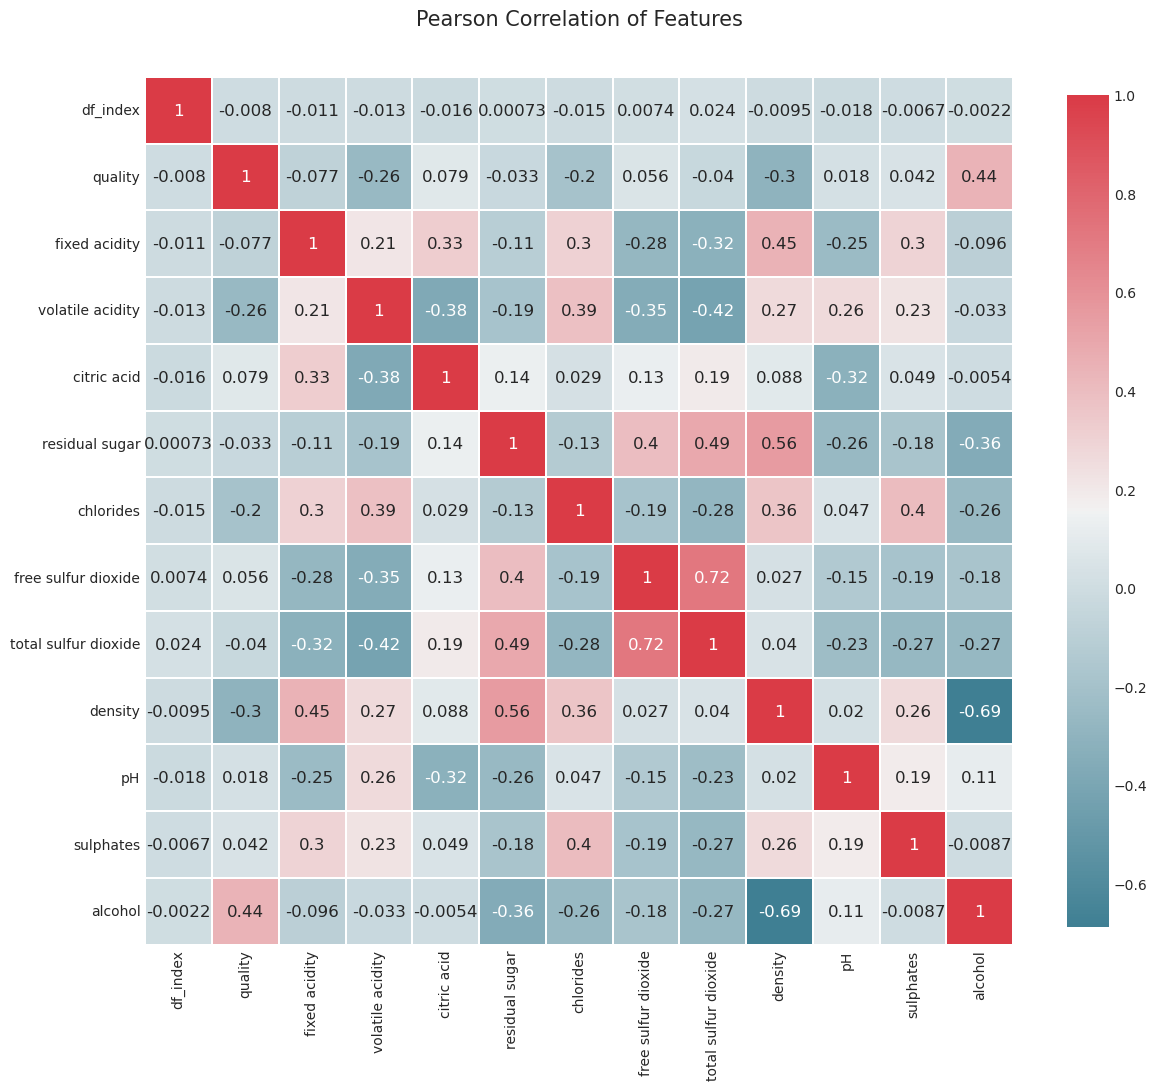

In [10]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train)

# 2. Start

In [11]:
target_name = ["quality"]
data_y = train[target_name[0]]
data_x = train.drop(labels=target_name, axis=1)
feature_names = np.array(data_x.columns)
print(feature_names)
print('-'*10)
print(data_y.head())
print('-'*10)
print(data_x.head())
print('-'*10)

['df_index' 'fixed acidity' 'volatile acidity' 'citric acid'
 'residual sugar' 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide'
 'density' 'pH' 'sulphates' 'alcohol' 'type']
----------
0    5
1    5
2    5
3    6
4    6
Name: quality, dtype: int64
----------
   df_index  fixed acidity  volatile acidity  citric acid  residual sugar  \
0         0            5.6             0.695         0.06             6.8   
1         1            8.8             0.610         0.14             2.4   
2         2            7.9             0.210         0.39             2.0   
3         3            7.0             0.210         0.31             6.0   
4         4            7.8             0.400         0.26             9.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.042                  9.0                  84.0  0.99432  3.44   
1      0.067                 10.0                  42.0  0.99690  3.19   
2      0.057                 21.0               

# 3. Data Processing

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_x["type"] = labelencoder.fit_transform(data_x["type"])
# test dataset도 미리 `type` feature을 바꿔주기
test["type"] = labelencoder.transform(test["type"])


In [13]:
data_x.head()

,df_index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,1
1,1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,0
2,2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,1
3,3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,1
4,4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,1


In [22]:
## Split Training and Validation Dataset
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, random_state=34)
print(f"train_x.shape: {train_x.shape}")
print(f"val_x.shape: {val_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"val_y.shape: {val_y.shape}")



train_x.shape: (4122, 13)
val_x.shape: (1375, 13)
train_y.shape: (4122,)
val_y.shape: (1375,)


In [23]:

## scale only the training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
val_y = scaler.transform(val_x)

# 4. Model = LightGBM

**요약 정리**

* light GBM은 가벼운게 특징 -> 빠르다
* 큰 사이즈 데이터를 다룰 수 있고, 적은 메모리를 사용함
* GPU 사용으로 training이 가능함
* 작은 데이터셋을 사용할 때는 추천하지 않음 -> overfitting되기 쉬움 (data point가 10,000개 이상일 때 추천함)
* 모델 파라미터가 100개 이상 있음

**파라미터 종류와 기능**

* max_depth : Tree의 최대 깊이를 말합니다. 이 파라미터는 모델 과적합을 다룰 때 사용됩니다. 만약 여러분의 모델이 과적합된 것 같다고 느끼신다면 제 조언은 max_depth 값을 줄이라는 것입니다.

* min_data_in_leaf : Leaf가 가지고 있는 최소한의 레코드 수입니다. 디폴트값은 20으로 최적 값입니다. 과적합을 해결할 때 사용되는 파라미터입니다.

* feature_fraction : Boosting (나중에 다뤄질 것입니다) 이 랜덤 포레스트일 경우 사용합니다. 0.8 feature_fraction의 의미는 Light GBM이 Tree를 만들 때 매번 각각의 iteration 반복에서 파라미터 중에서 80%를 랜덤하게 선택하는 것을 의미합니다.

* bagging_fraction : 매번 iteration을 돌 때 사용되는 데이터의 일부를 선택하는데 트레이닝 속도를 높이고 과적합을 방지할 때 주로 사용됩니다.

* early_stopping_round : 이 파라미터는 분석 속도를 높이는데 도움이 됩니다. 모델은 만약 어떤 validation 데이터 중 하나의 지표가 지난 early_stopping_round 라운드에서 향상되지 않았다면 학습을 중단합니다. 이는 지나친 iteration을 줄이는데 도움이 됩니다.

* lambda : lambda 값은 regularization 정규화를 합니다. 일반적인 값의 범위는 0 에서 1 사이입니다.

* min_gain_to_split : 이 파라미터는 분기하기 위해 필요한 최소한의 gain을 의미합니다. Tree에서 유용한 분기의 수를 컨트롤하는데 사용됩니다.

* max_cat_group : 카테고리 수가 클 때, 과적합을 방지하는 분기 포인트를 찾습니다. 그래서 Light GBM 알고리즘이 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾습니다. 디폴트 값은 64 입니다.



**참고 자료**

* https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
* 

In [24]:

import lightgbm as lgb
d_train = lgb.Dataset(train_x, label=train_y)
lgbm_params = {
    'learning_rate':0.05,
    'boosting_type': 'gbdt', #Gradient Boosting Decision Tree
    'objective': 'multiclass',
    'num_classes': 10,
    'metric': 'multi_logloss'
}

from datetime import datetime
start_timer = datetime.now()
clf = lgb.train(lgbm_params, d_train, 50) # 50 iterations
stop_timer = datetime.now()
train_time = stop_timer - start_timer
print(f"LGBM train time: {train_time}")
y_pred = clf.predict(val_x)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1756
[LightGBM] [Info] Number of data points in the train set: 4122, number of used features: 13
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -5.328361
[LightGBM] [Info] Start training from score -3.396840
[LightGBM] [Info] Start training from score -1.120688
[LightGBM] [Info] Start training from score -0.820804
[LightGBM] [Info] Start training from score -1.788852
[LightGBM] [Info] Start training from score -3.596706
[LightGBM] [Info] Start training from score -6.937799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM train time:

In [25]:
y_pred.shape

(1375, 10)

In [26]:
val_y.shape

(1375, 13)

In [17]:

correct = y_pred and val_y

print(np.sum(correct))
print(correct.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()